# Final Project: Bag of Words Method (Dog vs Cat Classification)

Hello! Welcome to my final project! Throughout this notebook, I will be exploring and implementing the nortious Bag of Words Method to distinguish pictures between dogs and cats. Based on the method of approach we learned in class, we will organize this project into three parts:
1. Dictionary Learning (Learn Visual Words using Clustering)
2. Encode build Bag of Words vectors for each image
3. Classify (Train and test data using BOWs)
4. Conclusion

There are **two main goal** of this project: 
1. Learning how this method is able to breakdown and analyze pictures using computer vision techniques we have learned in this course in combination of utilizing mathematical tools in the cluster and encode stage
2. The difference in accuarcy of the classification stage of <i>K nearest neighbors vs. Neural Network</i>

As you can most likely already tell, the style of approach that I have choosen to present this project is inspired by you, the professor :)! I geniuelly enjoyed the technique in which you presented the programming assignments and it being geared towards as a tutorial so I will do the same. 

Anything that has not been coded, made, or derived by me will be cited throughout this tutorial.

<b><i>With all of that being said, lets get to workin!</i></b>

Text(0.5, 1.0, 'My Dog Wesley')

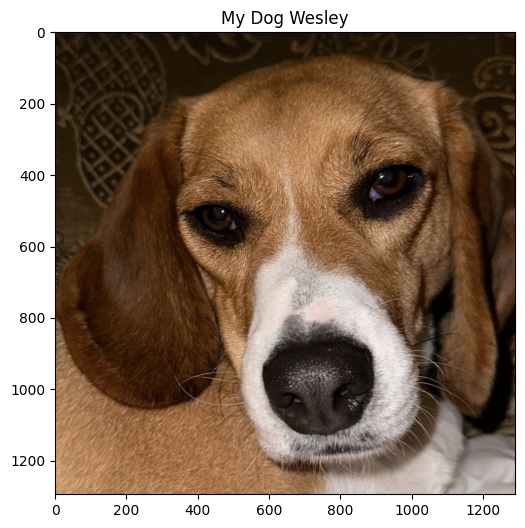

In [42]:
#Run this code to make sure all imports are loaded correctly w/o error 
#Picture of my dog should load
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
from skimage.feature import hog
# from cyvlfeat.hog import hog

#load_image() function from programming assignments
def load_image(filepath):
    img = Image.open(filepath)
    return (np.asarray(img).astype(float)/255)[:, :, :3]

plt.figure(figsize=(12, 6))
plt.imshow(load_image("./pictures/mypup.jpg"))
plt.title("My Dog Wesley")

Credits/Citations:

[1] Bag of Words Method Lecture 20 Slides \
[2] https://courses.cs.duke.edu/fall17/compsci527/notes/hog.pdf

# P.1 Dictionary Learning (Learn Visual Words using Clustering)

In this first part, we need to create a multitude of words in so that we are able to categorize the similarity of features into a dictionary. To achieve this, we will first devise a method to extract features from the image so that we produce a feature vector. From there, as the aforementioned we categorize the similarities through clustering which leads to our system being able to learn the words. To be more specific, our <b>two step process</b> for this part will be as follows:

1. Compute Feature Descriptor Per Image Using <i>Histogram of Oriented Gradient</i>
2. Classify the Features to Produce a Dictonary using <i>K-means Clustering</i>

## P.1.1 Compute Feature Descriptor Per Image Using Histogram of Oriented Gradient

Histogram of Oriented Gradient (HoG) is a feature descriptor which can capture edge information and object appeareances through computing gradient direction and magnitude within specified localized portions of an image in combination with histograms. We use this to produce a percise feature vector for then later can be used to produce words in our dictionary. The function is defined by me in accordance to the research papers that I have found. The **indepth procedure** is as follows:


<h4><b>1. Compute the Gradients in Both Directions of the Image</b></h4>

There are two ways to perform this step. 

You can use what we learn in class by convoluting the images using the Sobel Filters: 
$$I_x =  \begin{bmatrix} -1 & 0 & 1 \\ \end{bmatrix}$$ 
$$I_y =  \begin{bmatrix} -1 \\ 0 \\ 1 \\ \end{bmatrix}$$
Or by computing their central differences:
$$I_x(r,c) = I(r,c+1) - I(r,c-1)$$ 
$$I_y(r,c) = I(r-1,c) - I(r+1, c)$$
Where $I_x$ is the $x$-derivative of the image $I$, $I_y$ is the $y$-derivative of the image $I$, $r$ is the row, and $c$ is the column. 

I opted out to compute their central differences. As we learned in class and based on the research paper, convolution with the Sobel Filters results in highly accurate derivates accross the image in the presence of noise. However, we may want to account for some noise as it may contribute to the accuracy of feature detection in later steps of our procedure. In addition, noise averaging will occur in the histogram computation. 



(921600,)


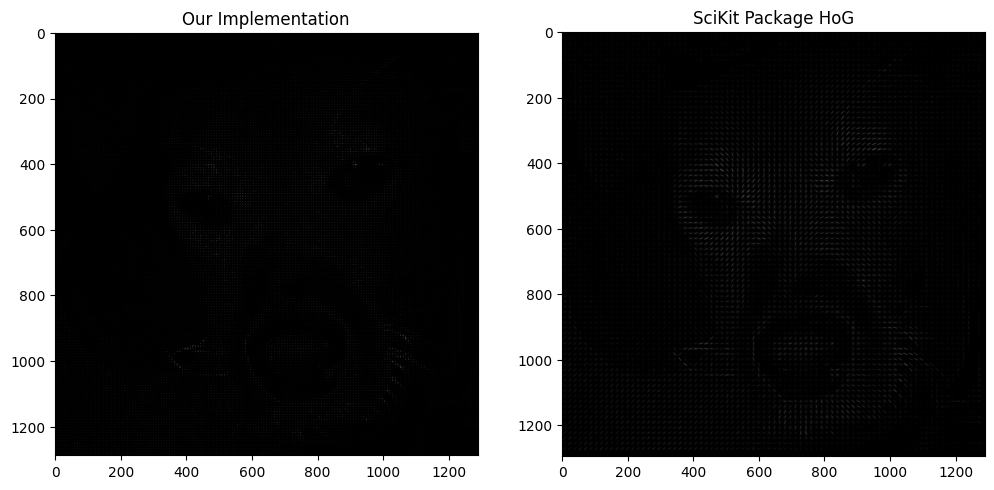

In [143]:
from skimage.draw import line_aa

#Switching Image back to Grayscale 
def load_image(filepath):
    img = Image.open(filepath).convert('L')  
    return (np.asarray(img).astype(float) / 255)


image = load_image("./pictures/mypup.jpg")

""" Self-Defined Function to compute our HoG descriptor """
def compute_hog(image):
    #Intializing our initial variables: cells, bins, width
    C = 8
    B = 9
    w = 180/B
    epsilon = 0.001
    hog_descriptor = list()
    
    # First Compute Derivates in X and Y direction using central difference
    Ix = np.zeros_like(image)
    Iy = np.zeros_like(image)
    
    Ix[:, 1:-1] = image[:, 2:] - image[:, :-2]
    Iy[1:-1, :] = image[2:, :] - image[:-2, :]


    #Compute "mu constant" and "theta"
    mu = np.sqrt(np.square(Ix) + np.square(Iy))
    theta = (180 / np.pi) * (np.arctan2(Iy, Ix) % np.pi)
    #Getting our "sliding window" of CxC
    cell_x = image.shape[1] // C
    cell_y = image.shape[0] // C

    for i in range(cell_y):
        for j in range(cell_x):
            cell_magnitude = mu[i*C:(i+1)*C, j*C:(j+1)*C]
            cell_orientation = theta[i*C:(i+1)*C, j*C:(j+1)*C]
            hist, _ = np.histogram(cell_orientation, bins=B, range=(0, 180), weights=cell_magnitude)
            hog_descriptor.append(hist)

    
    # Reshape the descriptor array
    hog_descriptor = np.reshape(hog_descriptor, (cell_y, cell_x, B))

    # Normalize histograms over blocks of 2x2 cells
    block_normed = list()
    for y in range(cell_y - 1):
        for x in range(cell_x - 1):
            block = hog_descriptor[y:y+2, x:x+2, :].ravel()
            norm = np.linalg.norm(block, ord=2)  # L2 norm
            block = block / (norm**2 + epsilon)
            block_normed.append(block)

    hog_features = np.concatenate(block_normed)
    hog_features = hog_features / (np.linalg.norm(hog_features)**2 + epsilon)
    return hog_descriptor, hog_features

""" ChatGPT function to display our hog_descriptor """
def visualize_hog(img, hog_descriptor, cell_size, orientations):
    # Dimensions of each cell
    C = cell_size
    
    # Number of cells along x and y
    num_cells_x = img.shape[1] // C
    num_cells_y = img.shape[0] // C
    
    # Create an array to hold the visualized HoG features
    hog_image = np.zeros((num_cells_y * C, num_cells_x * C), dtype=float)
    
    # Go through each cell's histograms
    max_mag = np.array(hog_descriptor).max()
    for y in range(num_cells_y):
        for x in range(num_cells_x):
            for o in range(orientations):
                # Get the orientation angle and magnitude
                angle = 180 / orientations * o
                magnitude = hog_descriptor[y, x, o] / max_mag
                
                # Get the center of the cell
                center_x = x * C + C // 2
                center_y = y * C + C // 2
                
                # Calculate the direction vector ends based on the angle and magnitude
                dx = magnitude * C * np.cos(np.deg2rad(angle))
                dy = magnitude * C * np.sin(np.deg2rad(angle))
                
                # Draw the line on the hog_image
                x1 = center_x + dx / 2
                y1 = center_y - dy / 2
                x2 = center_x - dx / 2
                y2 = center_y + dy / 2
                rr, cc, val = line_aa(int(y1), int(x1), int(y2), int(x2))
                hog_image[rr, cc] += val * magnitude
    
    return hog_image


#SciKit hog function to compare results
hog_descriptor, hog_features = compute_hog(image)

fd, scikit_hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
)


personal_hog_image = visualize_hog(image, hog_descriptor, 8, 9)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Our Implementation")
plt.imshow(personal_hog_image, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("SciKit Package HoG")
plt.imshow(scikit_hog_image, cmap="gray")